## HW4

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

In [14]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [15]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [16]:
cols = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays','previous', 'poutcome', 'y']

In [17]:
df_new = df[cols]
df_new.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [19]:
df_new['y'] = df_new['y'].replace({'yes':1, 'no':0});

In [20]:
df_full_train, df_test = train_test_split(df_new, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)


In [21]:
len(df_new), len(df_train), len(df_val), len(df_test)

(45211, 27126, 9042, 9043)

### Q1

In [22]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [23]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 5.2+ MB


In [24]:
df_new.head(3)

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0


In [25]:
df_new.campaign.nunique()

48

In [26]:
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [27]:
numerical = ['age','balance','day','duration','campaign', 'pdays', 'previous']

In [28]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [29]:
del df_train['y']
del df_val['y']
del df_test['y']

In [30]:
scores = []
for i in numerical:
    auc_score = roc_auc_score(y_train, df_train[i])  # Fixed column access and function
    if auc_score < 0:
        scores.append([i, roc_auc_score(y_train, -df_train[i])])  # Correct column access
    else:
        scores.append([i, auc_score])

In [31]:
scores

[['age', 0.48781428247265596],
 ['balance', 0.5888313805382317],
 ['day', 0.474042117616092],
 ['duration', 0.8147002759670778],
 ['campaign', 0.42854569843178414],
 ['pdays', 0.5901276247352144],
 ['previous', 0.5985653242764153]]

In [32]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [34]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [35]:
dv, model = train(df_train, y_train)

In [36]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [37]:
y_pred = predict(df_val, dv, model)

In [41]:
roc_auc_score(y_val, y_pred)

0.9006884713944792

### Q3

In [49]:
import matplotlib.pyplot as plt

In [53]:
def tpr_fpr_dataframe(y_val, y_pred):
    recall = []
    precision = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        p = tp / (tp + fp)
        r = tp / (tp + fn)
        
        precision.append(p)
        recall.append(r)

    return recall, precision

In [54]:
recall, precision = tpr_fpr_dataframe(y_val,y_pred)
thresholds = np.linspace(0, 1, 101)

In [56]:
len(recall), len(precision)

(101, 101)

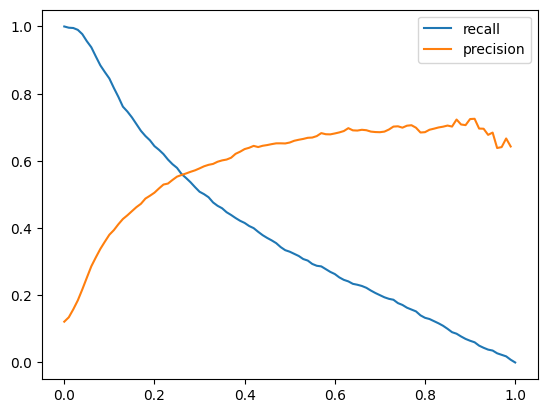

In [57]:
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.legend()
plt.show()

### Q4

In [66]:
def f1_score(y_val, y_pred):

    f1_score = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        p = tp / (tp + fp)
        r = tp / (tp + fn)

        f_1 = 2*(p*r/(p+r))

        f1_score.append(f_1)

    return f1_score


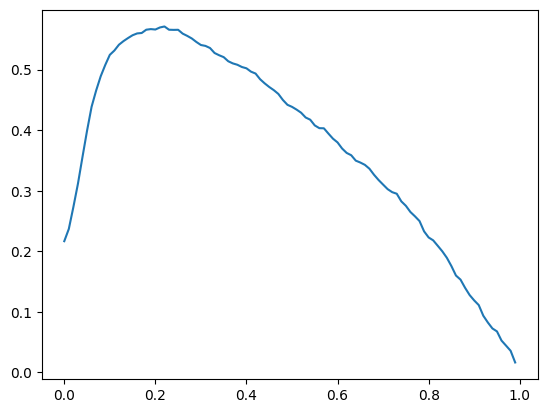

In [67]:
f1_score = f1_score(y_val, y_pred)
plt.plot(thresholds, f1_score)

In [70]:
# calculate the maximum f1_score threshold

### Q5

In [71]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [75]:
#n_splits = 5

for n_split in tqdm([2,3,4,5]):
    kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('n_split=%s %.3f +- %.3f' % (n_split, np.mean(scores), np.std(scores)))

 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

n_split=2 0.905 +- 0.002


 50%|█████     | 2/4 [00:06<00:07,  3.59s/it]

n_split=3 0.906 +- 0.002


 75%|███████▌  | 3/4 [00:12<00:04,  4.52s/it]

n_split=4 0.906 +- 0.003


100%|██████████| 4/4 [00:20<00:00,  5.05s/it]

n_split=5 0.906 +- 0.006
